For run this code, you must be installed the PandExo package and the PandExo data.  Pleas follow the instructions in the [PandExo documentation](https://natashabatalha.github.io/PandExo/installation.html).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandexo.engine.justdoit as jdi
import numpy as np
import os
import pandas as pd
import multirex as mrex

### Generate spectra with only CO2

In [2]:
import multirex as mrex
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [3]:
mrex.Util.get_gases()
mrex.Util.get_stellar_phoenix()
mrex.Util.list_gases()

The path where the opacity database will be downloaded is :  current directory


Downloading...
From (original): https://drive.google.com/uc?id=1z7R0hD1IBuYo-nnl7dpE_Ls2337a0uv6
From (redirected): https://drive.google.com/uc?id=1z7R0hD1IBuYo-nnl7dpE_Ls2337a0uv6&confirm=t&uuid=dc026f22-80b3-4d1f-a06c-00d386ddfdcf
To: e:\astro\MultiREx-public\examples\research\opacidades-todas.zip
100%|██████████| 1.55G/1.55G [01:15<00:00, 20.5MB/s]


The path where the Phoenix stellar spectra will be downloaded is :  current directory


Downloading...
From (original): https://drive.google.com/uc?id=1fgKjDu9H26y5WMwRZaMCuSpHhx8zc0pR
From (redirected): https://drive.google.com/uc?id=1fgKjDu9H26y5WMwRZaMCuSpHhx8zc0pR&confirm=t&uuid=5f260ced-4884-41cc-a56a-d9610fdfdf87
To: e:\astro\MultiREx-public\examples\research\Phoenix.zip
100%|██████████| 2.46G/2.46G [01:39<00:00, 24.6MB/s]


Available gases in the database:
['CO2', 'DMS', 'O2', 'NO2', 'CH3Cl', 'CO', 'C2H6', 'HCN', 'CH4', 'N2', 'H2O', 'O3']


The directory to Phoenix already exists in the specified path:  current directory


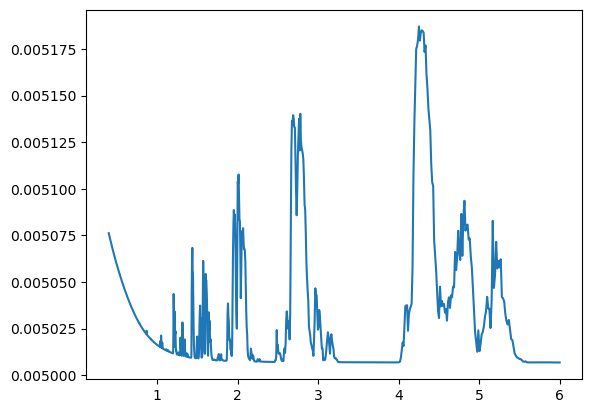

In [4]:
trappist1= mrex.Star(temperature=2566,radius=0.1192, mass=0.0898,phoenix_path="")
trappist1e= mrex.Planet(radius=0.920,mass=0.692)
# abiotic atmosphere
atm00= mrex.Atmosphere(temperature=287,base_pressure=1e5,
                           top_pressure=1e-3,composition={"CO2":-2},fill_gas="N2")

trappist1e.set_atmosphere(atm00)

sistema=mrex.System(planet=trappist1e,star=trappist1,
                    sma=0.02925)
sistema.make_tm()


# Seleccionar los elementos de la lista usando los índices
wn_grid=mrex.wavenumber_grid(0.4,6,1000)

_ , rp2_rs2 = sistema.generate_spectrum(wn_grid)

plt.plot(1e4/wn_grid,rp2_rs2)

## save 2 columns, wl and flux
np.savetxt("pandexo_spec.txt",np.array([1e4/wn_grid,rp2_rs2]).T)

## Creación de los instrumentos

In [5]:
exo_dict = jdi.load_exo_dict()
n_transits = 10

exo_dict['observation']['sat_level'] = 80    #saturation level in percent of full well
exo_dict['observation']['sat_unit'] = '%'
exo_dict['observation']['noccultations'] = n_transits #number of transits
exo_dict['observation']['R'] = None          #fixed binning. I usually suggest ZERO binning.. you can always bin later
                                             #without having to redo the calcualtion
exo_dict['observation']['baseline_unit'] = 'total'  #Defines how you specify out of transit observing time
                                                    #'frac' : fraction of time in transit versus out = in/out
                                                    #'total' : total observing time (seconds)
exo_dict['observation']['baseline'] = 0.9535*3*60.0*60.0 #in accordance with what was specified above (total observing time)

exo_dict['observation']['noise_floor'] = 0   #this can be a fixed level or it can be a filepath
                                             #to a wavelength dependent noise floor solution (units are ppm)

Star data from NASA Exoplanet Archive

In [6]:
exo_dict['star']['type'] = 'phoenix'        #phoenix or user (if you have your own)
exo_dict['star']['mag'] = 11.354               #magnitude of the system
exo_dict['star']['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
exo_dict['star']['temp'] = 2566             #in K
exo_dict['star']['metal'] = 0.0             # as log Fe/H
exo_dict['star']['logg'] = 5.2396              #log surface gravity cgs

In [10]:
exo_dict['planet']['type'] ='user'                       #tells pandexo you are uploading your own spectrum
exo_dict['planet']['exopath'] = 'pandexo_spec.txt'            #path to your spectrum
exo_dict['planet']['w_unit'] = 'um'                      #other options include "um","nm" ,"Angs", "sec" (for phase curves)
exo_dict['planet']['f_unit'] = 'rp^2/r*^2'               #other options are 'fp/f*'
exo_dict['planet']['transit_duration'] = 0.9535*60.0*60.0   #transit duration
exo_dict['planet']['td_unit'] = 's'                      #Any unit of time in accordance with astropy.units can be added

In [11]:
## set NIRSpec Prism instrument

inst_dict=jdi.load_mode_dict('NIRSpec Prism')
inst_dict["configuration"]["detector"]["subarray"]="sub512"
inst_dict["configuration"]["detector"]["ngroup"] =6

Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


Text(0.5, 1.0, 'JWST PandExo Simulation\n 10 transits ')

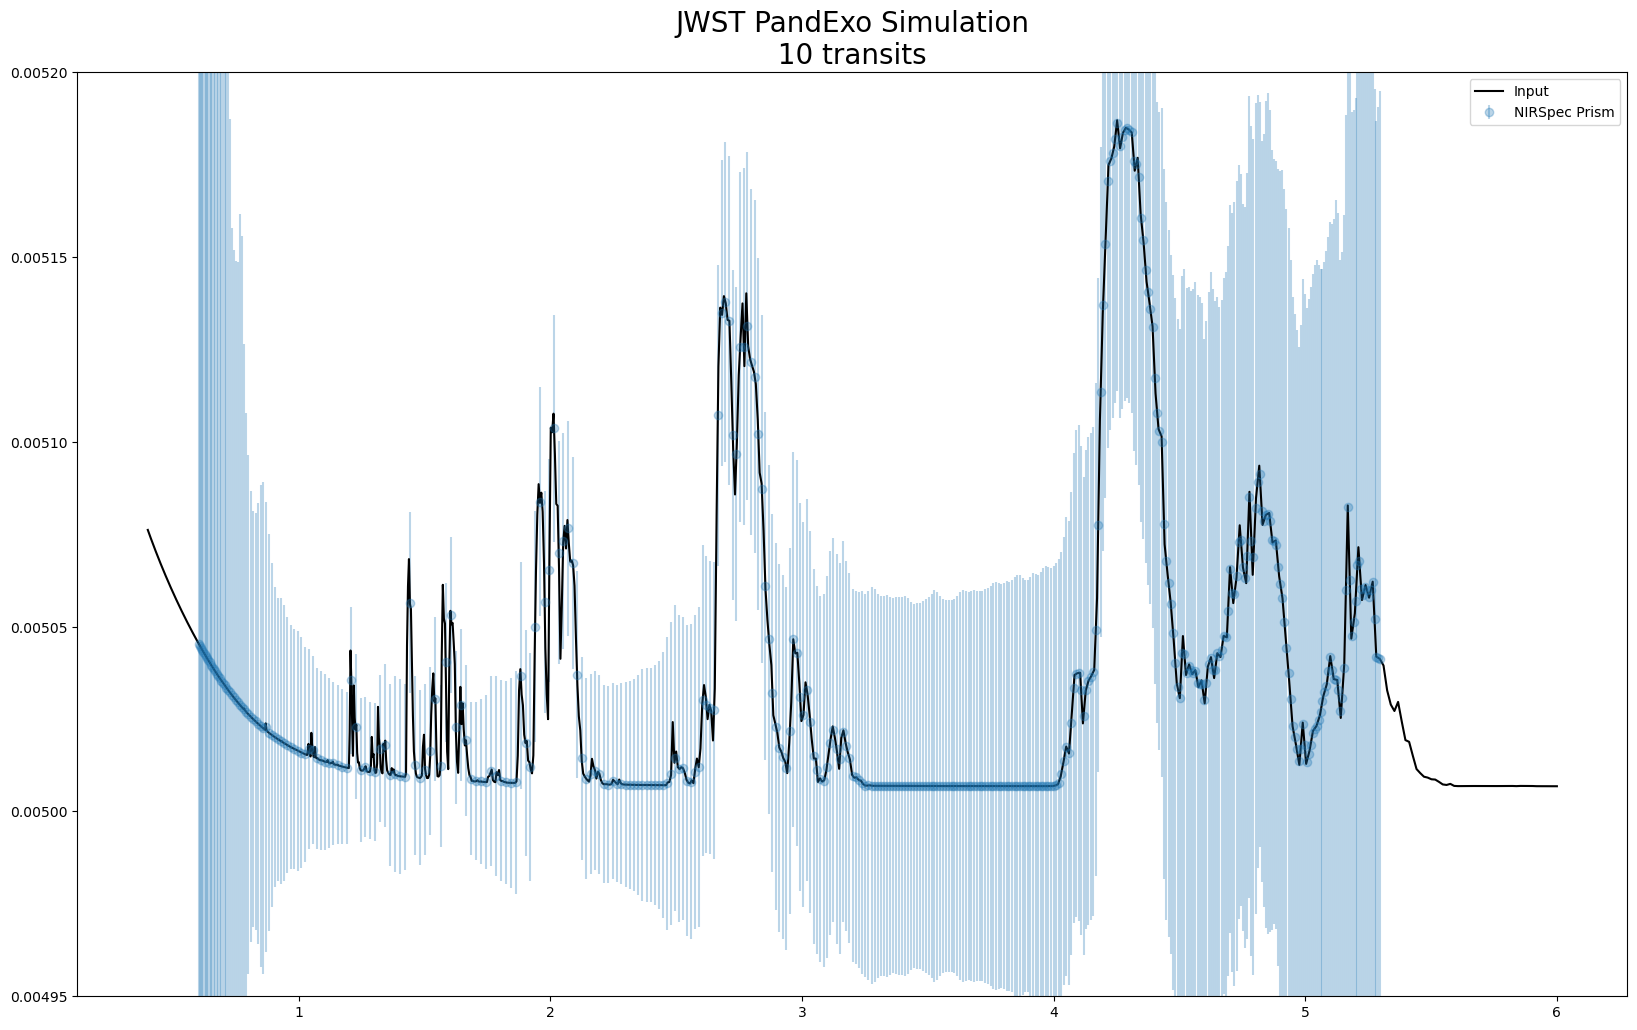

In [12]:
result = jdi.run_pandexo(exo_dict,inst_dict)

## plot the results
import matplotlib.pyplot as plt

import pandas as pd

## load spec2.txt
spec = pd.read_csv('pandexo_spec.txt', header=None, delimiter=' ')
spec

plt.figure(figsize=(20,12))
plt.errorbar(result["FinalSpectrum"]["wave"], result["FinalSpectrum"]["spectrum"], 
             yerr=result["FinalSpectrum"]["error_w_floor"], fmt='o', label='NIRSpec Prism'
            ,alpha=0.3)
plt.plot(spec[0], spec[1], label='Input',color='black')
plt.legend()

plt.ylim(0.00495, 0.00520)
plt.title(f'JWST PandExo Simulation\n {n_transits} transits ',fontsize=20)

## Evaluar evolución del Ruido

  0%|          | 0/100 [00:00<?, ?it/s]

Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


  1%|          | 1/100 [00:14<23:51, 14.46s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


  2%|▏         | 2/100 [00:24<19:43, 12.08s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


  3%|▎         | 3/100 [00:35<18:11, 11.26s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


  4%|▍         | 4/100 [00:45<17:42, 11.07s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


  5%|▌         | 5/100 [00:57<17:51, 11.27s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


  6%|▌         | 6/100 [01:04<15:14,  9.73s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


  7%|▋         | 7/100 [01:11<13:37,  8.79s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


  8%|▊         | 8/100 [01:17<12:27,  8.13s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


  9%|▉         | 9/100 [01:24<11:39,  7.69s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 10%|█         | 10/100 [01:33<11:59,  7.99s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 11%|█         | 11/100 [01:40<11:21,  7.66s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 12%|█▏        | 12/100 [01:46<10:48,  7.37s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 13%|█▎        | 13/100 [01:54<10:59,  7.58s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 14%|█▍        | 14/100 [02:10<14:09,  9.87s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 15%|█▌        | 15/100 [02:23<15:42, 11.08s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 16%|█▌        | 16/100 [02:38<16:51, 12.04s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 17%|█▋        | 17/100 [02:53<17:47, 12.86s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 18%|█▊        | 18/100 [03:07<18:13, 13.34s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 19%|█▉        | 19/100 [03:22<18:40, 13.84s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 20%|██        | 20/100 [03:42<21:05, 15.82s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 21%|██        | 21/100 [03:53<18:41, 14.20s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 22%|██▏       | 22/100 [04:00<15:49, 12.17s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 23%|██▎       | 23/100 [04:08<13:45, 10.72s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 24%|██▍       | 24/100 [04:15<12:20,  9.74s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 25%|██▌       | 25/100 [04:22<11:17,  9.03s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 26%|██▌       | 26/100 [04:30<10:29,  8.51s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 27%|██▋       | 27/100 [04:37<10:04,  8.28s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 28%|██▊       | 28/100 [04:47<10:25,  8.68s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 29%|██▉       | 29/100 [04:55<10:00,  8.45s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 30%|███       | 30/100 [05:03<09:38,  8.27s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 31%|███       | 31/100 [05:11<09:21,  8.14s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 32%|███▏      | 32/100 [05:19<09:08,  8.07s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 33%|███▎      | 33/100 [05:27<09:04,  8.13s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 34%|███▍      | 34/100 [05:35<08:55,  8.12s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 35%|███▌      | 35/100 [05:47<09:56,  9.18s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 36%|███▌      | 36/100 [05:55<09:30,  8.91s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 37%|███▋      | 37/100 [06:03<09:07,  8.68s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 38%|███▊      | 38/100 [06:11<08:47,  8.50s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 39%|███▉      | 39/100 [06:19<08:32,  8.40s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 40%|████      | 40/100 [06:28<08:26,  8.45s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 41%|████      | 41/100 [06:36<08:13,  8.36s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 42%|████▏     | 42/100 [06:56<11:20, 11.74s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 43%|████▎     | 43/100 [07:10<11:46, 12.40s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 44%|████▍     | 44/100 [07:21<11:24, 12.23s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 45%|████▌     | 45/100 [07:33<11:05, 12.10s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 46%|████▌     | 46/100 [07:45<10:42, 11.90s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 47%|████▋     | 47/100 [07:57<10:44, 12.17s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 48%|████▊     | 48/100 [08:10<10:35, 12.23s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 49%|████▉     | 49/100 [08:21<10:13, 12.04s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 50%|█████     | 50/100 [08:33<09:50, 11.81s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 51%|█████     | 51/100 [08:45<09:44, 11.94s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 52%|█████▏    | 52/100 [08:59<10:01, 12.53s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 53%|█████▎    | 53/100 [09:17<11:05, 14.15s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 54%|█████▍    | 54/100 [09:33<11:16, 14.70s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 55%|█████▌    | 55/100 [09:51<11:46, 15.70s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 56%|█████▌    | 56/100 [10:07<11:38, 15.89s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 57%|█████▋    | 57/100 [10:21<10:56, 15.26s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 58%|█████▊    | 58/100 [10:35<10:20, 14.77s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 59%|█████▉    | 59/100 [10:47<09:37, 14.10s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 60%|██████    | 60/100 [11:01<09:18, 13.96s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 61%|██████    | 61/100 [11:16<09:24, 14.47s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 62%|██████▏   | 62/100 [11:28<08:41, 13.72s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 63%|██████▎   | 63/100 [11:39<07:57, 12.90s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 64%|██████▍   | 64/100 [11:50<07:22, 12.30s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 65%|██████▌   | 65/100 [12:01<06:54, 11.84s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 66%|██████▌   | 66/100 [12:12<06:32, 11.55s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 67%|██████▋   | 67/100 [12:23<06:12, 11.28s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 68%|██████▊   | 68/100 [12:33<05:50, 10.97s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 69%|██████▉   | 69/100 [12:45<05:51, 11.34s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 70%|███████   | 70/100 [12:54<05:18, 10.63s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 71%|███████   | 71/100 [13:02<04:46,  9.87s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 72%|███████▏  | 72/100 [13:10<04:18,  9.23s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 73%|███████▎  | 73/100 [13:18<04:03,  9.02s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 74%|███████▍  | 74/100 [13:37<05:10, 11.94s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 75%|███████▌  | 75/100 [13:54<05:38, 13.55s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 76%|███████▌  | 76/100 [14:12<05:56, 14.86s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 77%|███████▋  | 77/100 [14:30<06:00, 15.68s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 78%|███████▊  | 78/100 [14:46<05:48, 15.84s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 79%|███████▉  | 79/100 [14:55<04:49, 13.79s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 80%|████████  | 80/100 [15:07<04:27, 13.38s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 81%|████████  | 81/100 [15:18<03:57, 12.50s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 82%|████████▏ | 82/100 [15:28<03:32, 11.80s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 83%|████████▎ | 83/100 [15:37<03:06, 10.97s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 84%|████████▍ | 84/100 [15:46<02:43, 10.20s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 85%|████████▌ | 85/100 [15:55<02:28,  9.91s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 86%|████████▌ | 86/100 [16:04<02:14,  9.58s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 87%|████████▋ | 87/100 [16:12<02:00,  9.26s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 88%|████████▊ | 88/100 [16:21<01:49,  9.12s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 89%|████████▉ | 89/100 [16:30<01:40,  9.15s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 90%|█████████ | 90/100 [16:40<01:33,  9.39s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 91%|█████████ | 91/100 [16:53<01:34, 10.49s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 92%|█████████▏| 92/100 [17:03<01:21, 10.16s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 93%|█████████▎| 93/100 [17:21<01:29, 12.76s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 94%|█████████▍| 94/100 [17:36<01:19, 13.18s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 95%|█████████▌| 95/100 [17:45<00:59, 11.99s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 96%|█████████▌| 96/100 [17:53<00:42, 10.74s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 97%|█████████▋| 97/100 [18:01<00:30, 10.05s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 98%|█████████▊| 98/100 [18:09<00:18,  9.47s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


 99%|█████████▉| 99/100 [18:18<00:09,  9.25s/it]

End out of Transit
Starting In Transit Simulation
End In Transit
Running Single Case w/ User Instrument Dict
Starting Out of Transit Simulation


100%|██████████| 100/100 [18:26<00:00, 11.07s/it]

End out of Transit
Starting In Transit Simulation
End In Transit


Text(0, 0.5, '$R_p^2/R_s^2$')

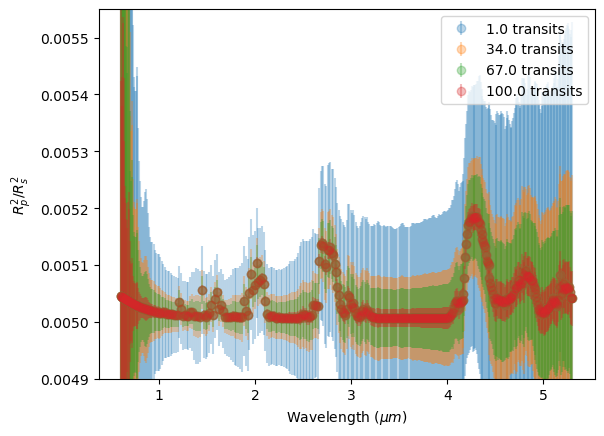

In [13]:
observed=dict(
    NIRSpec_Prism=[],
)
n_obs=np.linspace(1,100,100)
from tqdm import tqdm
for n in tqdm(n_obs):
    exo_dict['observation']['noccultations'] = n
    result1 = jdi.run_pandexo(exo_dict,inst_dict)
    observed['NIRSpec_Prism'].append(result1["FinalSpectrum"])
    
plt.errorbar(observed['NIRSpec_Prism'][0]["wave"], observed['NIRSpec_Prism'][0]["spectrum"],
                yerr=observed['NIRSpec_Prism'][0]["error_w_floor"], fmt='o',
                label=f"{n_obs[0]} transits" ,alpha=0.3)
plt.errorbar(observed['NIRSpec_Prism'][4]["wave"], observed['NIRSpec_Prism'][4]["spectrum"],
             yerr=observed['NIRSpec_Prism'][4]["error_w_floor"], fmt='o',
             label=f"{n_obs[33]} transits" ,alpha=0.3)
plt.errorbar(observed['NIRSpec_Prism'][9]["wave"], observed['NIRSpec_Prism'][9]["spectrum"],
                yerr=observed['NIRSpec_Prism'][9]["error_w_floor"], fmt='o',
                label=f"{n_obs[66]} transits" ,alpha=0.3)
plt.errorbar(observed['NIRSpec_Prism'][-1]["wave"], observed['NIRSpec_Prism'][-1]["spectrum"],
             yerr=observed['NIRSpec_Prism'][-1]["error_w_floor"], fmt='o',
             label=f"{n_obs[-1]} transits" ,alpha=0.3)
             
#plt.xlim(0.6, 12)
plt.ylim(0.0049, 0.00555)
plt.legend()
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('$R_p^2/R_s^2$')


### SNR evolution

277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.0051862

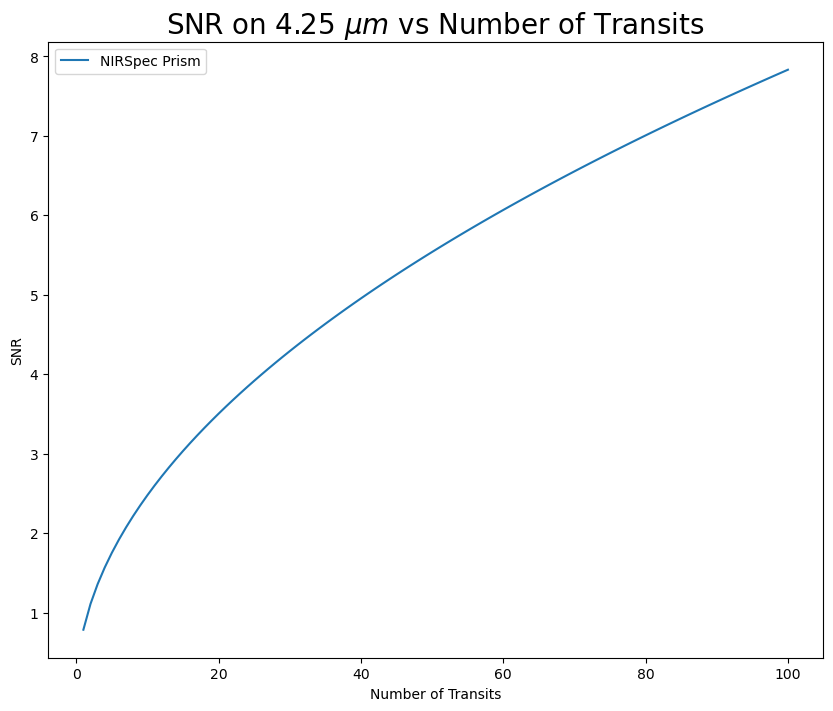

In [14]:
## calculate SNR

## find idx where spec is max
idx = np.argmax(observed['NIRSpec_Prism'][0]["spectrum"])

## SNR is max value divided by the error
SNR=np.zeros(len(n_obs))
for i in range(len(n_obs)):
    idx = np.argmax(observed['NIRSpec_Prism'][i]["spectrum"])
    print(idx)
    print(observed['NIRSpec_Prism'][i]["spectrum"][idx])
    print(max(observed['NIRSpec_Prism'][i]["spectrum"]))
    signal = (max(observed['NIRSpec_Prism'][i]["spectrum"])-
              min(observed['NIRSpec_Prism'][i]["spectrum"]))
    SNR[i] = signal/observed['NIRSpec_Prism'][i]["error_w_floor"][idx]

## plot SNR vs n transits
plt.figure(figsize=(10,8))
plt.plot(n_obs, SNR, label='NIRSpec Prism')
plt.title(f'SNR on {observed["NIRSpec_Prism"][0]["wave"][idx]:.2f} $\mu m $ vs Number of Transits',fontsize=20)
plt.xlabel('Number of Transits')
plt.ylabel('SNR')
plt.legend()

## Plot the limist of RF detection for different SNR

277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.005186240476451419
277
0.005186240476451419
0.0051862

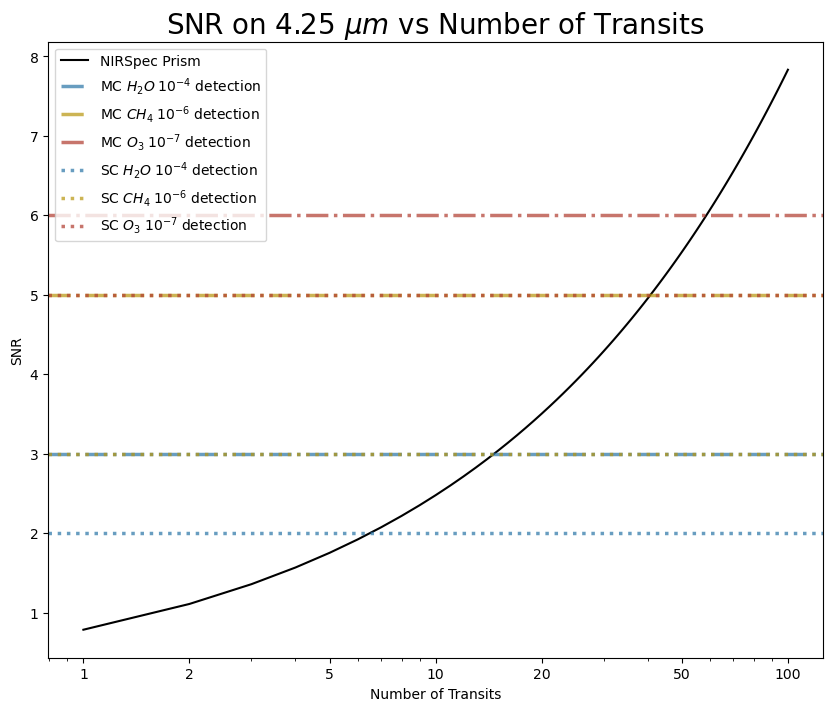

In [15]:
## calculate SNR

## find idx where spec is max
idx = np.argmax(observed['NIRSpec_Prism'][0]["spectrum"])

## SNR is max value divided by the error
SNR=np.zeros(len(n_obs))
for i in range(len(n_obs)):
    idx = np.argmax(observed['NIRSpec_Prism'][i]["spectrum"])
    print(idx)
    print(observed['NIRSpec_Prism'][i]["spectrum"][idx])
    print(max(observed['NIRSpec_Prism'][i]["spectrum"]))
    signal = (max(observed['NIRSpec_Prism'][i]["spectrum"])-
              min(observed['NIRSpec_Prism'][i]["spectrum"]))
    SNR[i] = signal/observed['NIRSpec_Prism'][i]["error_w_floor"][idx]


## plot SNR vs n transits
plt.figure(figsize=(10,8))
plt.plot(n_obs, SNR, label='NIRSpec Prism',color='black')
plt.axhline(3, color='#2874A6', linestyle='-.',
            label='MC $H_2O\; 10^{-4}$ detection',
            alpha=0.7,linewidth=2.5)
plt.axhline(5, color='#B7950B', linestyle='-.',
            label='MC $CH_4\; 10^{-6}$ detection',
            alpha=0.7,linewidth=2.5)
plt.axhline(6, color= "#B03A2E", linestyle='-.',
            label='MC $O_3\; 10^{-7}$ detection',
            alpha=0.7,linewidth=2.5)
plt.axhline(2,color='#2874A6', linestyle=':',
            label='SC $H_2O\; 10^{-4}$ detection',
            alpha=0.7,linewidth=2.5)
plt.axhline(3, color='#B7950B', linestyle=':',
            label='SC $CH_4\; 10^{-6}$ detection',
            alpha=0.7,linewidth=2.5)
plt.axhline(5, color= "#B03A2E", linestyle=':',
            label='SC $O_3\; 10^{-7}$ detection',
            alpha=0.7,linewidth=2.5)
plt.title(f'SNR on {observed["NIRSpec_Prism"][0]["wave"][idx]:.2f} $\mu m $ vs Number of Transits',
          fontsize=20)
plt.xlabel('Number of Transits')
plt.ylabel('SNR')
## x scale log with 10 ticks
plt.xscale('log')
plt.xticks([1,2,5,10,20,50,100])
plt.legend()
## show numbers on x axis
plt.gca().get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.legend()

## Select correct interval with "low" noise.

In [16]:
## import plotly
import plotly.graph_objects as go

In [19]:
sim_obs = result1.copy()
## plto #wave vs error_w_floor
fig = go.Figure()
fig.add_trace(go.Scatter(x=sim_obs["FinalSpectrum"]["wave"], y=sim_obs["FinalSpectrum"]['error_w_floor'],
                         mode='markers'))
fig.update_layout(title='Wave vs Error_w_floor',
                  xaxis_title='Wave',
                  yaxis_title='Error_w_floor')
fig.show()

In [23]:
##plot spec
fig = go.Figure()
fig.add_trace(go.Scatter(x=sim_obs["FinalSpectrum"]["wave"][18:],
                         y=sim_obs["FinalSpectrum"]['spectrum'][18:],
                         error_y=dict(type='data',
                                      array=sim_obs["FinalSpectrum"]['error_w_floor'][18:])))



In [24]:
waves= sim_obs["FinalSpectrum"]["wave"][18:]
## save waves as txt
np.savetxt('waves.txt', waves, fmt='%.6f')